### Importing the theoretical $D_{l}$ obtained with CAMB (Lewis & Challinor 2011; Lewis et al. 2000)

These are the steps for generating a simple CMB map realization with white noise  following ( Sullivan et al. (2024)).\
1.Generate from CAMB or CLASS the desired power spectrum $C_\ell$. (or another option we can download  a precomputed one; e.g.\
for Planck mission)\
2.Convolve the power spectrum with the beam $B_\ell$ and pixel window function $P_\ell$\
3.Add the desired noise spectrum $\epsilon_\ell$ \
4.Generate the map (from the randomised $\a_{l m}$)\.
5.Mask the map (ensure that the mask is apodised for centain procedures).
                                                                                  
                                                                            

#### Step 1: Generating the input $C_\ell s$ from CAMB

In [203]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from input_camb import *
import healpy as hp

[matplotlib.pyplot] Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [205]:
# This Dl is used as input for synthetic map (with len(el)=2551)
Dl

array([   0.        ,    0.        , 1028.01454306, ...,   66.35034063,
         66.2225099 ,   66.09623955])

In [206]:
ls=np.arange((Dl.shape[0]))

In [207]:
ls

array([   0,    1,    2, ..., 2548, 2549, 2550])

##### Step 2: convolving the power spectrum with the beam $B_\ell$ and pixel window function $P_\ell$

Following Planck collaboration (2018), we choose the $FWHM = 5 min$ as we in a Planck SMICA map.\
$C_l^{obs} = B_l^{2} C_l$

In [210]:
fwhm=np.radians(5/60)

lmax=2000
B_l=hp.gauss_beam(fwhm,lmax, pol=False)
D_l=Dl[:2001]/(B_l**2)

#### Step 3:Computing the window beam function 

In [212]:
P_l=hp.sphtfunc.pixwin(nside, pol=False, lmax=2000)
Dl_input=D_l/(P_l**2)

#### Step 4: Adding the white noise $\epsilon_\ell = 4.5 \times 10^{-5} \mu K^{2}$ following\ Planck collaboration (2018)
#### $Dl=Dl_{obs} -\epsilon_\ell$

In [213]:
Dl_input=Dl_input - 4.5*10**(-5)/(B_l*P_l)**2

In [214]:
lmax = 2000
nside=2048
mapa_cl = hp.sphtfunc.synfast(Dl_input, nside=nside, lmax =lmax, fwhm=np.radians(1/60), new= True)

[healpy] Sigma is 0.424661 arcmin (0.000124 rad) 
[healpy] -> fwhm is 1.000000 arcmin


[matplotlib.colorbar] locator: <healpy.projaxes.BoundaryLocator object at 0x7f018d7b87c0>


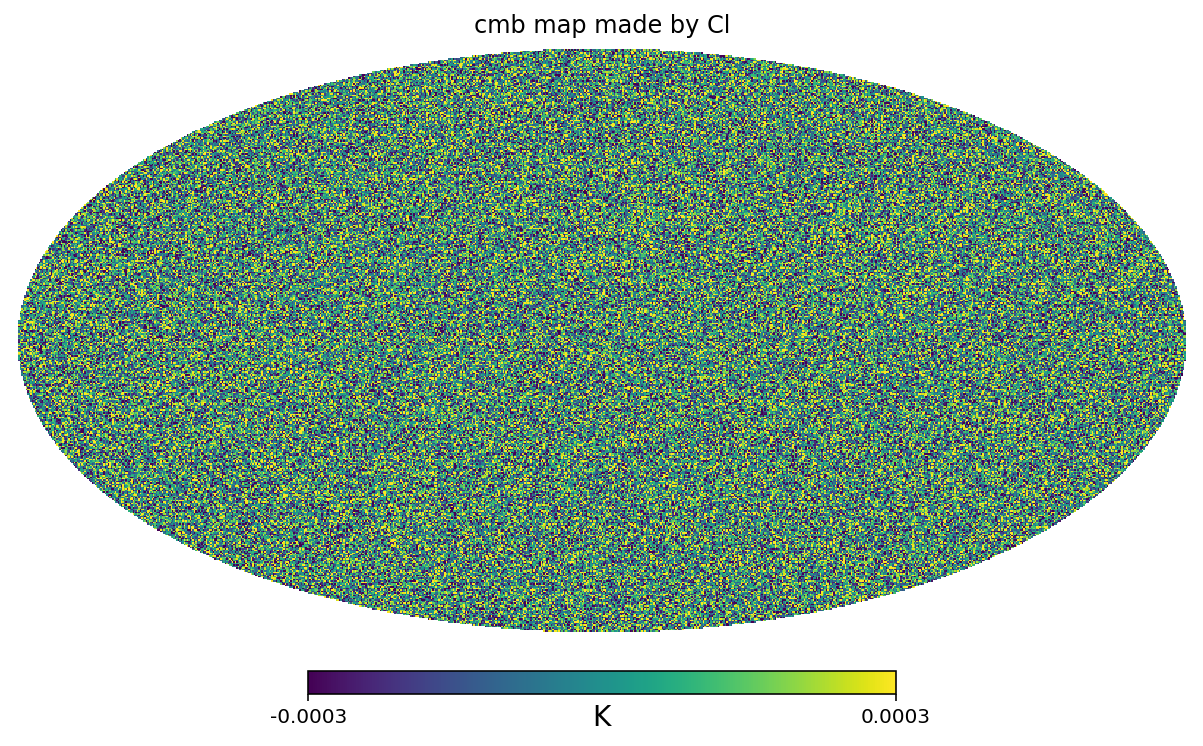

In [215]:
hp.mollview(mapa_cl*(1e-8), title = 'cmb map made by Cl', unit = 'K', min=-3e-4, max=3e-4)

In [216]:
#Saving the map
cmb_map=np.save('CMB_map', mapa_cl)

In [217]:
# ells
Cls=hp.anafast(mapa_cl, lmax=2000)
el=np.arange(len(Cls))
el

array([   0,    1,    2, ..., 1998, 1999, 2000])

In [218]:
# Total uncertainties due the cosmic variance and the noise of the map
# We remove the dipole and l=0
std_cls=np.sqrt(2 / (2*el[2:] + 1))*Cls[2:]
std_cls.shape
tot_err=std_cls
Cls[2:].shape

(1999,)

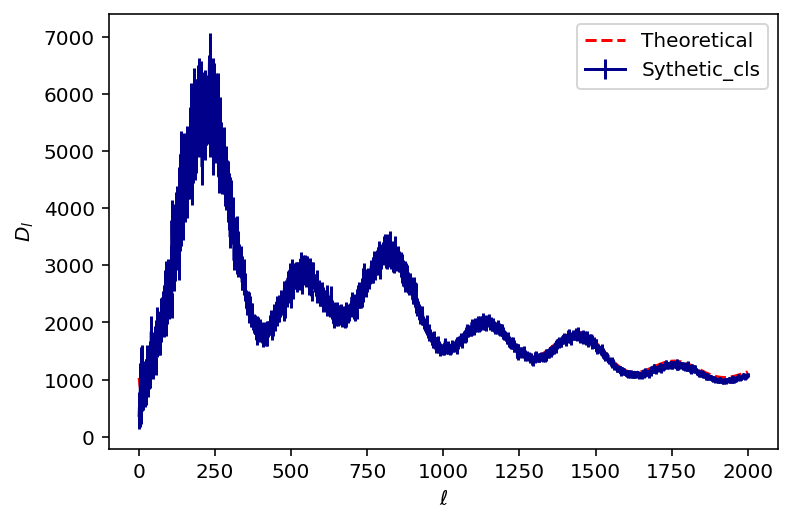

In [222]:
plt.plot(ls[2:2001],Dl_input[2:],'--',  color= 'r', label='Theoretical')
plt.errorbar(el[2:],Cls[2:],yerr=tot_err, color = 'darkblue', label='Sythetic_cls')
plt.xlabel('$\ell$')
plt.ylabel(r'$D_l$')
plt.legend()

In [250]:
len(el[2:])

1999

In [229]:
len(Cls[2:])

1999

In [231]:
len(tot_err)

1999

Converting the data in a numpy array to store in a txt file

We are going to save the file as txt file for our Cobaya likelihood

In [232]:
data_cls=np.column_stack((el[2:],Cls[2:],tot_err))

In [233]:
# Define the path to the text file
text_file_path = 'my_cl_data.txt'

In [234]:
# Save the numpy array as txt file with  space as delimiter
np.savetxt(text_file_path, data_cls, delimiter=' ')

## MCMC with Cobaya (Lewis  & Torrado 2021)

In [181]:
from cobaya.likelihood import Likelihood
import os

I establish the Likelihood 

In [255]:
class MyClsLikelihood(Likelihood):
    def initialize(self):
        """Prepare any computation, importing necessary code, files, etc."""
        # Load your data file, for example, experimental Cls
        self.ell, self.data_Cl_TT, self.error = np.loadtxt('my_cl_data.txt', unpack=True)
    
    def get_requirements(self):
        """Return dictionary specifying quantities calculated by a theory code."""
        # Request C_l^{TT} (temperature) up to the maximum ell in your data
        return {'Cl': {'tt': 2000}}
    
    def logp(self, **params_values):
        """Compute the log-likelihood given a set of parameter values."""
        # Get the theoretical Cls from the theory code (e.g., CAMB or CLASS)
        cls = self.provider.get_Cl(ell_factor=True, units='muK2')  # Now fetching 'Cl', not 'unlensed_cl'
        
        # Calculate chi-squared: sum of squared differences between data and theory Cls
        chi2 = np.sum(((self.data_Cl_TT - cls['tt'][2:]) / self.error) ** 2)
        
        # Return the log-likelihood (-0.5 * chi2)
        return -0.5 * chi2

Sampling the parameters

The base set of cosmological parameters we sample over are $\Omega_b h^{2}$ and $\Omega_c h^{2}$, the physical barion density and the CDM density
to critical density of universe, $h=H_0/(100 Km s^{-1} Mpc^{-1})$.

In [ ]:
info_params = {
    "debug": True,
    "likelihood": {
        "MyClsLikelihood": MyClsLikelihood
    },
    "theory": {
        "camb": {
            "extra_args": {
                "lmax": 2000
            }
        }
    },
    "params": {
        "ombh2": {
            "prior": {"min": 0.005, "max": 0.1}, 
            "ref": {"dist": "norm", "loc": 0.024, "scale": 0.001}, 
            "proposal": 0.001,
            'latex': r"\Omega_\mathrm{b} h^2"
        },
        "omch2": {
            "prior": {"min": 0.001, "max": 0.99}, 
            "ref": {"dist": "norm", "loc": 0.12, "scale": 0.001}, 
            "proposal": 0.005, 
            'latex': r"\Omega_\mathrm{c} h^2"
        },
        "H0": {
            "prior": {"min": 20, "max": 100}, 
            'latex': r"H_0"
        }
    },
    "sampler": {
        "mcmc": {
            "max_tries": 1000
        }
    },
    "debug": True
}

# Running Cobaya
from cobaya import run
updated_info, sampler = run(info_params)


[outputdummy] No output requested. Doing nothing.
[run] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: false
    extra_args:
      lmax: 2000
    ignore_obsolete: false
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
likelihood:
  MyClsLikelihood:
    type: []
    speed: -1
    stop_at_error: false
    version: null
    external: !!python/name:__main__.MyClsLikelihood ''
params:
  ombh2:
    prior:
      min: 0.005
      max: 0.1
    ref:
      dist: norm
      loc: 0.024
      scale: 0.001
    proposal: 0.001
    latex: \Omega_\mathrm{b} h^2
    renames:
    - omegabh2
  omch2:
    prior:
      min: 0.001
      max: 0.99
    ref:
      dist: norm
      loc: 0.12
      scale: 0.001
    proposal: 0.005
    latex: \Omega_\mathrm{c} h^2
    renames

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([2.49674838e-02, 1.17621593e-01, 4.95406475e+01])
[prior] Got logpriors (internal) = -2.0170872999328604
[model] Posterior to be computed for parameters {'ombh2': 0.024967483845138118, 'omch2': 0.11762159254642399, 'H0': 49.540647543380715}
[prior] Evaluating prior at array([2.49674838e-02, 1.17621593e-01, 4.95406475e+01])
[prior] Got logpriors (internal) = -2.0170872999328604
[model] Got input parameters: {'ombh2': 0.024967483845138118, 'omch2': 0.11762159254642399, 'H0': 49.540647543380715}
[camb.transfers] Got parameters {'ombh2': 0.024967483845138118, 'omch2': 0.11762159254642399, 'H0': 49.540647543380715}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.024967483845138118, 'omch2': 0.11762159254642399, 'H0': 49.540647543380715} and {'lmax': 2000}
[camb] Got parameters {}
[camb] Computing new state
[myclslikelihood] Got parameters {}
[myclslikelihood] Computing ne

[camb.transfers] Got parameters {'ombh2': 0.02398843745425968, 'omch2': 0.12072827310853541, 'H0': 93.14177871071801}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.02398843745425968, 'omch2': 0.12072827310853541, 'H0': 93.14177871071801} and {'lmax': 2000}
[camb] Got parameters {}
[camb] Computing new state
[myclslikelihood] Got parameters {}
[myclslikelihood] Computing new state
[myclslikelihood] Ignored error at evaluation and assigned 0 likelihood (set 'stop_at_error: True' as an option for this component to stop here and print a traceback). Error message: ValueError('operands could not be broadcast together with shapes (1999,) (2049,) ')
[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([2.36520486e-02, 1.18002172e-01, 6.52835569e+01])
[prior] Got logpriors (internal) = -2.0170872999328604
[model] Posterior to be computed for parameters {'ombh2': 0.023652048576870678, 'omch2': 0.11800217183737187, 'H0': 65.283

[model] Calculation failed, skipping rest of calculations 
[prior] Evaluating prior at array([2.56410681e-02, 1.20999515e-01, 2.69370206e+01])
[prior] Got logpriors (internal) = -2.0170872999328604
[model] Posterior to be computed for parameters {'ombh2': 0.025641068079691732, 'omch2': 0.12099951462798081, 'H0': 26.93702061890752}
[prior] Evaluating prior at array([2.56410681e-02, 1.20999515e-01, 2.69370206e+01])
[prior] Got logpriors (internal) = -2.0170872999328604
[model] Got input parameters: {'ombh2': 0.025641068079691732, 'omch2': 0.12099951462798081, 'H0': 26.93702061890752}
[camb.transfers] Got parameters {'ombh2': 0.025641068079691732, 'omch2': 0.12099951462798081, 'H0': 26.93702061890752}
[camb.transfers] Computing new state
[camb] Setting parameters: {'ombh2': 0.025641068079691732, 'omch2': 0.12099951462798081, 'H0': 26.93702061890752} and {'lmax': 2000}
[camb] Got parameters {}
[camb] Computing new state
[myclslikelihood] Got parameters {}
[myclslikelihood] Computing new st

In [241]:
import getdist
from getdist import plots, MCSamples

In [242]:
import getdist.plots as gdplt

In [245]:
sampler.products()

{'sample':    weight  minuslogpost     ombh2  omch2  minuslogprior  minuslogprior__0  \
 0     1.0           inf  0.021995  0.121      -3.152386         -3.152386   
 
    chi2  chi2__My_custom_likelihood  
 0   inf                         inf  }